In [27]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm

In [5]:
#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'

In [10]:
# define conversion function
def Tg_yr_m3(conc_grd_s,vol,mr):
    flux_box = (conc_grd_s*mr*per_sec_to_per_yr)/g_to_Tg #Tg per year per box
    flux_m3 = flux_box/vol #Tg per year per m3
    return flux_m3
def Tg_yr_box(conc_grd_s,vol,mr):
    flux_box = (conc_grd_s*mr*per_sec_to_per_yr)/g_to_Tg #Tg per year per box
    return flux_box
n_a = 6.02e23
mr_ch4 = 16
per_sec_to_per_yr = 60*60*24*360
g_to_Tg = 1e12

In [20]:
# Import flux data
data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_oh_flux_PI.nc',chunks={'time':24})
flux_949 = data_949.m01s50i041[:]
data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_CH4_OH_tendency.nc',chunks={'time':24})
flux_443 = data_443.ch4_oh_rxn_flux[:]

airm = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_airmass_atm.nc',chunks={'time':24})
airm = airm.airmass_atm

alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = alt.grid_cell_volume.data

In [21]:
# Convert data to Tg per m3 per year
fconv_949 = Tg_yr_m3(flux_949,vol,mr_ch4)
fconv_443 = Tg_yr_m3(flux_443,vol,mr_ch4)

In [22]:
# Time average data, cannot use dask average as it removes the coordinates from the variables, preventing .loc from working in next step
flux_949_mean = np.mean(fconv_949,axis=0)
flux_443_mean = np.mean(fconv_443,axis=0)

In [23]:
# Select longitudes wanted and remove altitudes above 20km
Alim = slice(0,55)

# Middle pacific           (no changes here, see what the agreement is)
lmPac = slice(180,190)
mPac_949 = dd.array.average(flux_949_mean.loc[Alim,:,lmPac],axis=2)
mPac_443 = dd.array.average(flux_443_mean.loc[Alim,:,lmPac],axis=2)
dmPac = mPac_949 - mPac_443

# Indian ocean (west)      (Changes here, look at distribution)
lwInd = slice(65,75)
wInd_949 = dd.array.average(flux_949_mean.loc[Alim,:,lwInd],axis=2)
wInd_443 = dd.array.average(flux_443_mean.loc[Alim,:,lwInd],axis=2)
dwInd = wInd_949 - wInd_443

# Middle Atlantic          (Changes through middle, try to determine nature of changes due to potentially unexpected large increase)
lmAtl = slice(315,335)
mAtl_949 = dd.array.average(flux_949_mean.loc[Alim,:,lmAtl],axis=2)
mAtl_443 = dd.array.average(flux_443_mean.loc[Alim,:,lmAtl],axis=2)
dmAtl = mAtl_949 - mAtl_443

# Middle Africa            (Relatively large changes, one up and one down, determine how high this goes too and compare to prescribed model)
lmAfr = slice(10,35)
mAfr_949 = dd.array.average(flux_949_mean.loc[Alim,:,lmAfr],axis=2)
mAfr_443 = dd.array.average(flux_443_mean.loc[Alim,:,lmAfr],axis=2)
dmAfr = mAfr_949 - mAfr_443

In [30]:
pdmAfr = dmAfr.compute()

In [47]:
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Reds', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 80)),
                       bottom(np.linspace(0, 0.1, 20))))
newcmp = ListedColormap(newcolors, name='Red_blue')

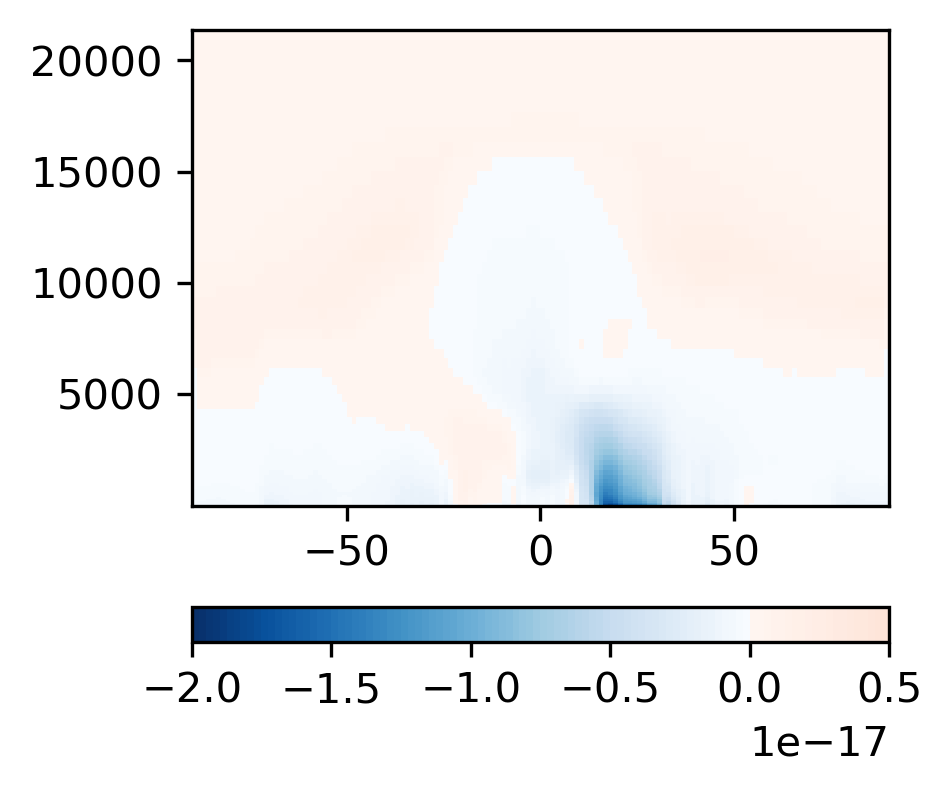

In [48]:
fig = plt.figure(figsize=(3,3), dpi=300)
ax = plt.axes()
plt.pcolormesh(fconv_443.latitude,alt.level_height[Alim],pdmAfr,cmap=newcmp,shading='nearest',vmin=-2e-17,vmax=0.5e-17)
plt.colorbar(orientation='horizontal')

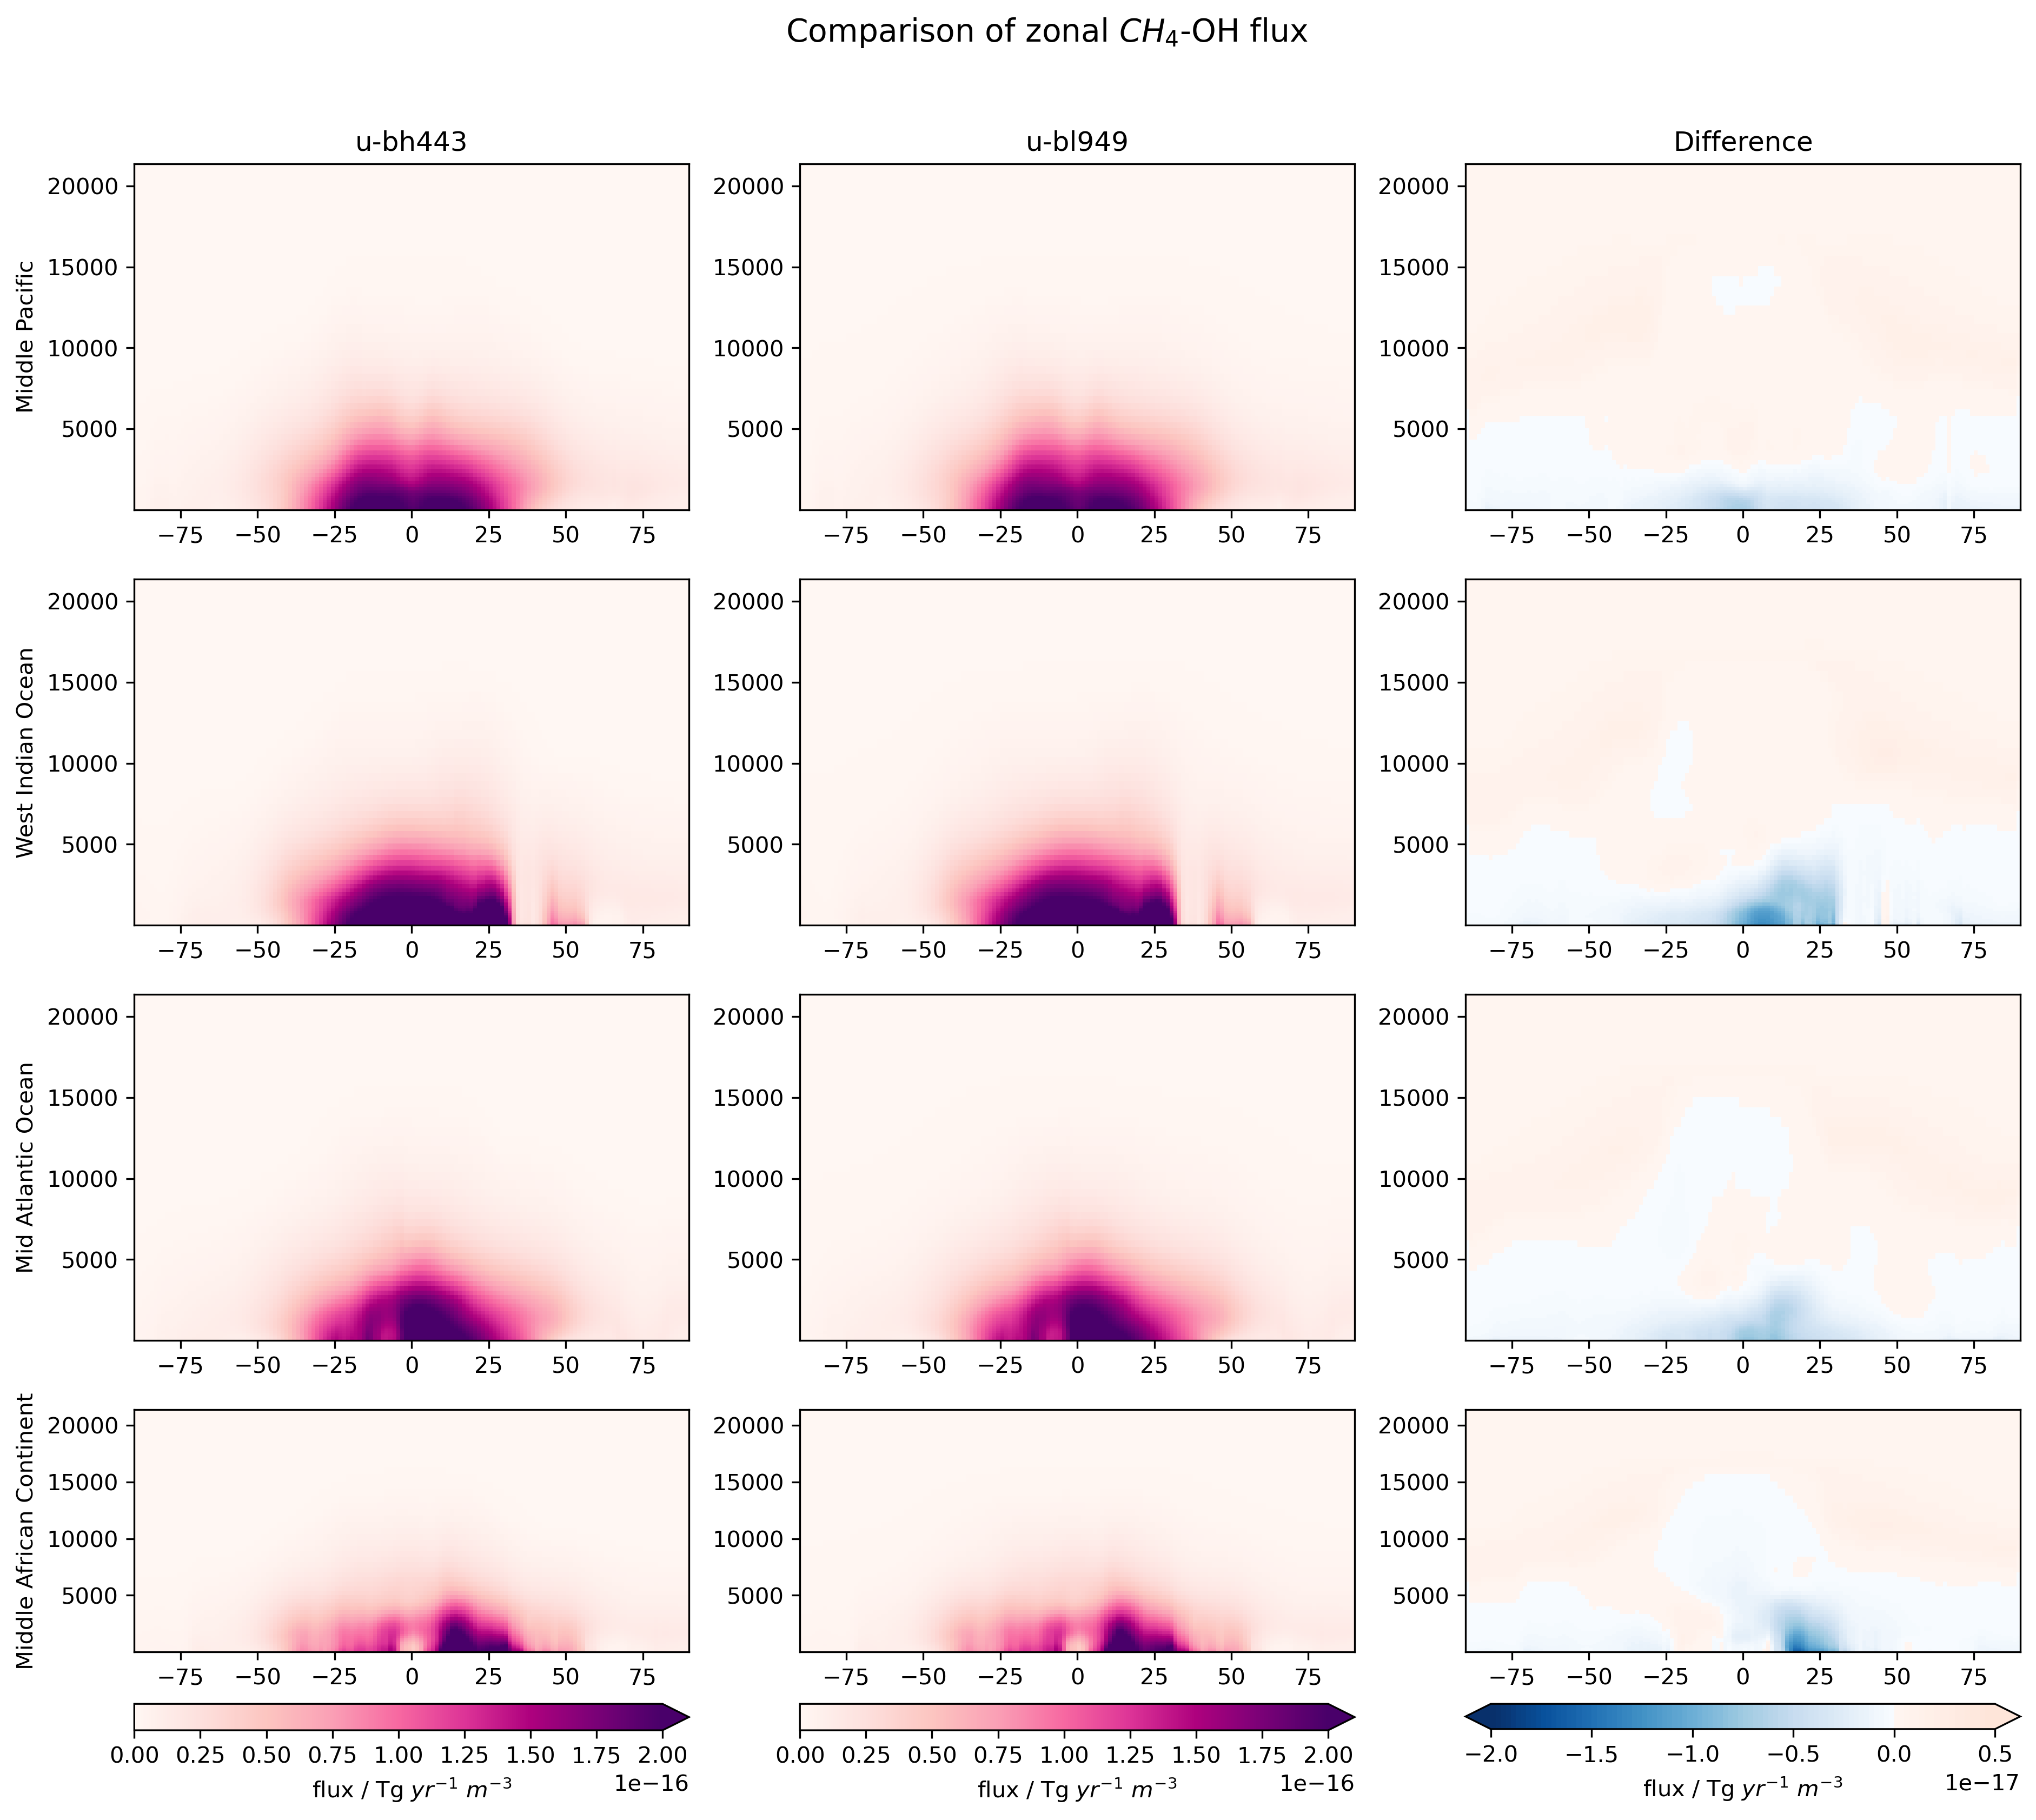

In [49]:
# Plot on subplots in the same format as for [OH] maps, compare changes in different regions maybe using pacific as a starting point as an area unaffected by methane emissions

fig, axs = plt.subplots(nrows=4,ncols=3, figsize=(15,13),dpi=300)
fig.suptitle('Comparison of zonal $CH_4$-OH flux',fontsize=14,y=0.95)

axs[0,0].set_title('u-bh443')
axs[0,0].set_ylabel('Middle Pacific') 
c1 = axs[0,0].pcolormesh(fconv_443.latitude,alt.level_height[Alim],mPac_443,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)
cb1 = fig.colorbar(c1, label= 'flux / Tg $yr^{-1}$ $m^{-3}$', orientation="horizontal",extend='max',ax=axs[3,0])

axs[0,1].set_title('u-bl949')
c2 = axs[0,1].pcolormesh(fconv_443.latitude,alt.level_height[Alim],mPac_949,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)
cb2 = fig.colorbar(c2, label= 'flux / Tg $yr^{-1}$ $m^{-3}$', orientation="horizontal",extend='max',ax=axs[3,1])

axs[0,2].set_title('Difference') 
c3 = axs[0,2].pcolormesh(fconv_443.latitude,alt.level_height[Alim],dmPac,cmap=newcmp,shading='nearest',vmin=-2e-17,vmax=0.5e-17)
cb3 = fig.colorbar(c3, label= 'flux / Tg $yr^{-1}$ $m^{-3}$', orientation="horizontal",extend='both',ax=axs[3,2])


axs[1,0].set_ylabel('West Indian Ocean') 
axs[1,0].pcolormesh(fconv_443.latitude,alt.level_height[Alim],wInd_443,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)

axs[1,1].pcolormesh(fconv_443.latitude,alt.level_height[Alim],wInd_949,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)

axs[1,2].pcolormesh(fconv_443.latitude,alt.level_height[Alim],dwInd,cmap=newcmp,shading='nearest',vmin=-2e-17,vmax=0.5e-17)


axs[2,0].set_ylabel('Mid Atlantic Ocean') 
axs[2,0].pcolormesh(fconv_443.latitude,alt.level_height[Alim],mAtl_443,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)

axs[2,1].pcolormesh(fconv_443.latitude,alt.level_height[Alim],mAtl_949,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)

axs[2,2].pcolormesh(fconv_443.latitude,alt.level_height[Alim],dmAtl,cmap=newcmp,shading='nearest',vmin=-2e-17,vmax=0.5e-17)


axs[3,0].set_ylabel('Middle African Continent') 
axs[3,0].pcolormesh(fconv_443.latitude,alt.level_height[Alim],mAfr_443,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)

axs[3,1].pcolormesh(fconv_443.latitude,alt.level_height[Alim],mAfr_949,cmap='RdPu',shading='nearest',vmin=0,vmax=2e-16)

axs[3,2].pcolormesh(fconv_443.latitude,alt.level_height[Alim],dmAfr,cmap=newcmp,shading='nearest',vmin=-2e-17,vmax=0.5e-17)

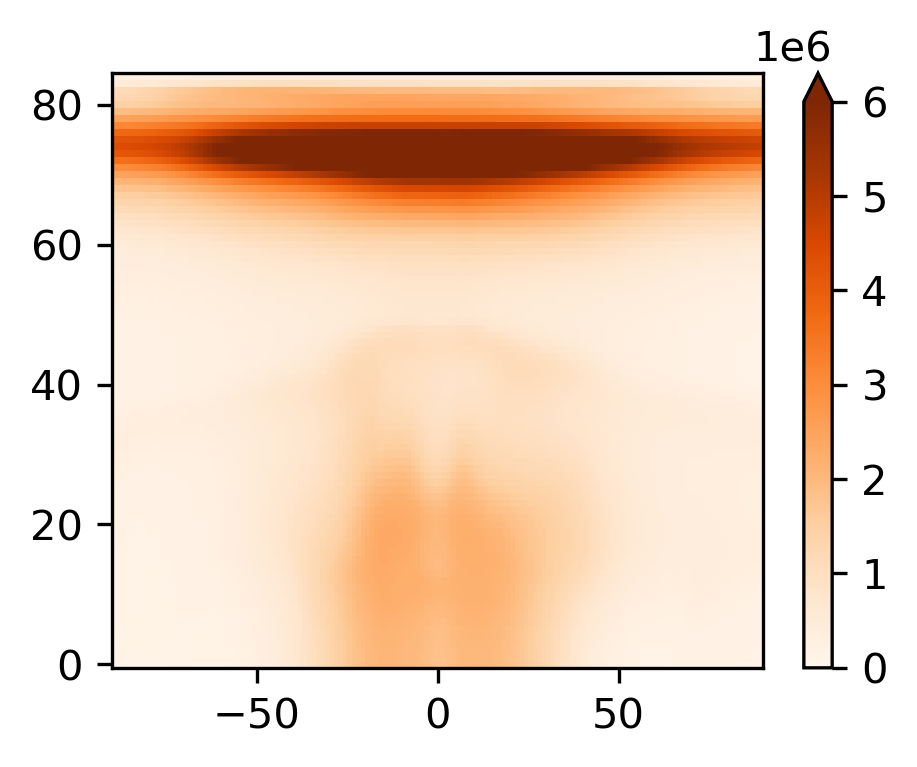

In [16]:
# # Plot data

# fig = plt.figure(figsize=(3.5,2.625), dpi=300)

# ax = plt.axes()
# plt.pcolormesh(oh_949.latitude,oh_949.model_level_number,mPac_949,shading='nearest',cmap='Oranges',vmin=0,vmax=6e6)
# plt.colorbar(extend='max')
# # plt.title('[OH] across IOD West box')

# ax1.set_title('u-bh443')
# ax1.coastlines(linewidth=0.5)
# bh_cyclic, lon_plot = add_cyclic_point(tmean_443, coord=lon)   
# c1 = ax1.pcolormesh(lon_plot,lat,bh_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0),vmin=0,vmax=5e6)
# cb1 = fig.colorbar(c1, label= '$[OH]_{GM}$ / molec. $cm^{-3}$', orientation="horizontal",extend='both',ax=ax1)

In [ ]:
# mPac_443.compute()
# mPac_949.compute()
# dmPac.compute()

# wInd_443.compute()
# wInd_949.compute()
# dwInd.compute()

# mAtl_443.compute()
# mAtl_949.compute()
# dmAtl.compute()

# mAfr_443.compute()
# mAfr_949.compute()
# dmAfr.compute();